In [94]:
import os
import pandas as pd
import math

df = pd.read_csv(os.path.expanduser('./data/DataSample.csv'))
POI_df = pd.read_csv(os.path.expanduser('./data/POIList.csv'))

In [95]:
df.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


In [96]:
POI_df

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
1,POI2,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


# 1. Clean Up

## Filter out rows with identical geoinfo and timest

In [97]:
filtered_df = df.drop_duplicates(subset=[' TimeSt', 'Latitude', 'Longitude'], keep=False)

In [98]:
filtered_df.head()

,_ID,TimeSt,Country,Province,City,Latitude,Longitude
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730


### POI1 and POI2 have the same geolocation, drop POI2, keep POI1

In [99]:
filtered_POI_df = POI_df.drop_duplicates(subset=[' Latitude', 'Longitude'])
filtered_POI_df

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


In [100]:
# Convert geolocation dataframe to a list of tuples
subset = filtered_POI_df[[" Latitude","Longitude"]]
POI_geolocations = [tuple(x) for x in subset.to_numpy()]

# 2. Label

In [101]:
# row in dataframe
def compute_closest_POI(row):
    lat = row['Latitude']
    long = row['Longitude']
    # compute squared distance differences with POI_geolocations
    min_dis = 999999
    min_POIID = 1
    POI_count = 0
    for geo in POI_geolocations:
        # compute least square differences
        dist = math.sqrt((lat-geo[0])**2 + (long-geo[1])**2)
        # update min distance
        if dist < min_dis:
            min_dis = dist
            min_POIID = POI_count
        POI_count += 1
    if min_POIID == 0:
        return "POI1"
    elif min_POIID == 1:
        return "POI3"
    else:
        return "POI4"

In [102]:
# Add a new column to the filtered_df
filtered_df['POI_label'] = filtered_df.apply(lambda row: compute_closest_POI(row), axis=1)

/var/folders/3t/mf04khg13xx1rr3170wrw8y40000gn/T/ipykernel_88533/3037355385.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['POI_label'] = filtered_df.apply(lambda row: compute_closest_POI(row), axis=1)


In [103]:
filtered_df

,_ID,TimeSt,Country,Province,City,Latitude,Longitude,POI_label
0,4516516,2017-06-21 00:00:00.143,CA,ON,Waterloo,43.49347,-80.49123,POI3
1,4516547,2017-06-21 18:00:00.193,CA,ON,London,42.93990,-81.27090,POI3
2,4516550,2017-06-21 15:00:00.287,CA,ON,Guelph,43.57760,-80.22010,POI3
3,4516600,2017-06-21 15:00:00.307,CA,ON,Stratford,43.37160,-80.97730,POI3
4,4516613,2017-06-21 15:00:00.497,CA,ON,Stratford,43.37160,-80.97730,POI3
...,...,...,...,...,...,...,...,...
22018,5614689,2017-06-21 13:23:01.370,CA,ON,London,42.96110,-81.24310,POI3
22020,5614801,2017-06-21 12:23:07.880,CA,ON,Saint Catharines,43.16440,-79.24560,POI3
22022,5614909,2017-06-21 00:23:07.903,CA,ON,Whitby,43.88730,-78.94220,POI3
22023,5614912,2017-06-21 11:23:07.953,CA,ON,Oakville,43.49340,-79.71260,POI3


# 3. Analysis

In [104]:
POI1_df = filtered_df[filtered_df['POI_label'] == 'POI1']
POI3_df = filtered_df[filtered_df['POI_label'] == 'POI3']
POI4_df = filtered_df[filtered_df['POI_label'] == 'POI4']

### For each POI, calculate the average and standard deviation of the distance between the POI to each of its assigned requests.

In [105]:
def compute_dist_to_POI(row, POI):
    lat = row['Latitude']
    long = row['Longitude']
    dist = math.sqrt((lat-POI[0])**2 + (long-POI[1])**2)
    return dist

In [106]:
POI1_df['dist_to_POI'] = POI1_df.apply(lambda r: compute_dist_to_POI(r, POI_geolocations[0]), axis=1)
POI3_df['dist_to_POI'] = POI3_df.apply(lambda r: compute_dist_to_POI(r, POI_geolocations[1]), axis=1)
POI4_df['dist_to_POI'] = POI4_df.apply(lambda r: compute_dist_to_POI(r, POI_geolocations[2]), axis=1)

/var/folders/3t/mf04khg13xx1rr3170wrw8y40000gn/T/ipykernel_88533/643788208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POI1_df['dist_to_POI'] = POI1_df.apply(lambda r: compute_dist_to_POI(r, POI_geolocations[0]), axis=1)
/var/folders/3t/mf04khg13xx1rr3170wrw8y40000gn/T/ipykernel_88533/643788208.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  POI3_df['dist_to_POI'] = POI3_df.apply(lambda r: compute_dist_to_POI(r, POI_geolocations[1]), axis=1)
/var/folders/3t/mf04khg13xx1rr3170wrw8y40000gn/T/ipyke

In [107]:
# POI1 average distance & std
POI1_avg_dist = POI1_df['dist_to_POI'].mean()
POI1_std_dist = POI1_df['dist_to_POI'].std()
print("POI1\nAverage distance: {:.4f} \nStd distance: {:.4f}".format(POI1_avg_dist, POI1_std_dist))

POI1
Average distance: 3.3531 
Std distance: 3.8496


In [108]:
# POI3 average distance & std
POI3_avg_dist = POI3_df['dist_to_POI'].mean()
POI3_std_dist = POI3_df['dist_to_POI'].std()
print("POI3\nAverage distance: {:.4f} \nStd distance: {:.4f}".format(POI3_avg_dist, POI3_std_dist))

POI3
Average distance: 5.5379 
Std distance: 2.8587


In [109]:
# POI4 average distance & std
POI4_avg_dist = POI4_df['dist_to_POI'].mean()
POI4_std_dist = POI4_df['dist_to_POI'].std()
print("POI4\nAverage distance: {:.4f} \nStd distance: {:.4f}".format(POI4_avg_dist, POI4_std_dist))

POI4
Average distance: 8.5224 
Std distance: 27.3346


### At each POI, draw a circle (with the center at the POI) that includes all of its assigned requests. Calculate the radius and density (requests/area) for each POI.

In [110]:
# POI1
# find the largest dist in POI1
POI1_radius = POI1_df['dist_to_POI'].max()
POI1_requests = POI1_df.shape[0]
POI1_area = math.pi * (POI1_radius ** 2)
POI1_density = POI1_requests / POI1_area
print('POI1:')
print('radius: {:.4f}'.format(POI1_radius))
print('density: {:.4f}'.format(POI1_density))

POI1:
radius: 24.8519
density: 4.4967


In [111]:
# POI3
# find the largest dist in POI3
POI3_radius = POI3_df['dist_to_POI'].max()
POI3_requests = POI3_df.shape[0]
POI3_area = math.pi * (POI3_radius ** 2)
POI3_density = POI3_requests / POI3_area
print('POI3:')
print('radius: {:.4f}'.format(POI3_radius))
print('density: {:.4f}'.format(POI3_density))

POI3:
radius: 20.1554
density: 6.9117


In [112]:
# POI4
# find the largest dist in POI4
POI4_radius = POI4_df['dist_to_POI'].max()
POI4_requests = POI4_df.shape[0]
POI4_area = math.pi * (POI1_radius ** 2)
POI4_density = POI4_requests / POI4_area
print('POI4:')
print('radius: {:.4f}'.format(POI4_radius))
print('density: {:.4f}'.format(POI4_density))

POI4:
radius: 192.7050
density: 0.2201


# 4. Modelling

In [113]:
POI1_df['dist_to_POI'].max()

24.851937229893878

In [114]:
filtered_POI_df

,POIID,Latitude,Longitude
0,POI1,53.546167,-113.485734
2,POI3,45.521629,-73.566024
3,POI4,45.224830,-63.232729


### To visualize the popularity of each *POI*, map them to a scale that ranges from -10 to 10. Please provide a mathematical model to implement this, considering extreme cases and outliers. Aim to be more sensitive around the average and give as much visual differentiability as possible.

In [115]:
import numpy as np
import seaborn as sns

In [116]:

def plot_POI_dist_vs_popularity(POI_df, plot_title) -> sns.scatterplot:
    """
    Plots a sns scatterplot where x-axis is the distance to its associated POI, and y-axis is the popularity
    The red bar is where the mean of "Distance to POI" locates
    """
    y_ax = [i for i in range(1, POI_df['dist_to_POI'].shape[0]+1)]
    p = sns.scatterplot(x=np.sort(POI_df['dist_to_POI']), y=y_ax)
    p.axvline(POI_df['dist_to_POI'].mean(), 0, 10, color='red', label='mean')
    p.set_xlabel('Distance to POI')
    p.set_ylabel('Popularity')
    p.set_title(plot_title)
    return p

<AxesSubplot:title={'center':'POI1'}, xlabel='Distance to POI', ylabel='Popularity'>

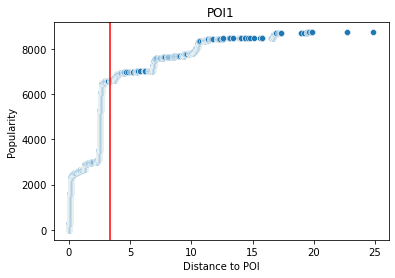

In [117]:
plot_POI_dist_vs_popularity(POI1_df, "POI1")

> We can see that there are two outliers on the top-right corner in the figure

<AxesSubplot:title={'center':'POI3'}, xlabel='Distance to POI', ylabel='Popularity'>

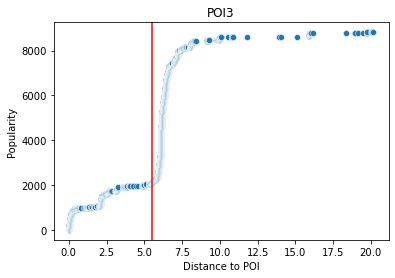

In [118]:
plot_POI_dist_vs_popularity(POI3_df, "POI3")

> The points look pretty consistent, there's a steady trend, so no outliers

<AxesSubplot:title={'center':'POI4'}, xlabel='Distance to POI', ylabel='Popularity'>

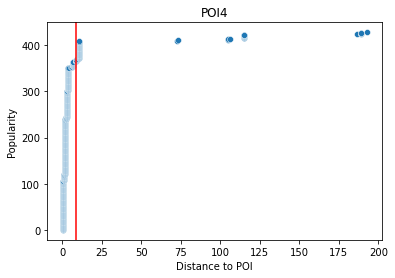

In [119]:
plot_POI_dist_vs_popularity(POI4_df, "POI4")

> Outliers are the points that are greater than 50 dist away from the POI

Submission
------
I get stuck at this step. I have tried many mathmatical functions (bounded functions like tanh and sigmoid) to transform the range of popularity to a scale from -10 to 10, while being sensitive around the average. 

I have tried my best ability to finish this task. I really enjoy the process of manipulating and analyzing data to try to find out the hidden meaning of POIs. Even though I didn't solve the problem completely, I enjoyed the process of finishing it. Leo, Thank you for giving me a lot of helpful advice! I really appreaciated!